# **Evaluation of Predictive Models for Diabetes Using Machine Learning**




Project by: Tabasum Hamdard

## Importing the necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from collections import defaultdict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import joblib


from imblearn.over_sampling import SMOTE




In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Get the Dataset
The dataset is sourced from Kaggle under the name of 'Diabetes prediction dataset. It has been published by the user id 'iammustafatz'. To get access to this data, navigate to the following link:

https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data

# Load the Dataset
 Firstly, we load the dataset into a Pandas DataFrame to begin data preprocessing.

In [ ]:

df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


# Data Pre-processing

### Data Exploration:
 Before proceeding with preprocessing we try to gain a comprehensive understanding of the dataset's properties, it's structure, statistics, missing values, and anomalies.

In [ ]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
df.corr()['diabetes']

age                    0.258008
hypertension           0.197823
heart_disease          0.171727
bmi                    0.214357
HbA1c_level            0.400660
blood_glucose_level    0.419558
diabetes               1.000000
Name: diabetes, dtype: float64

<AxesSubplot:>

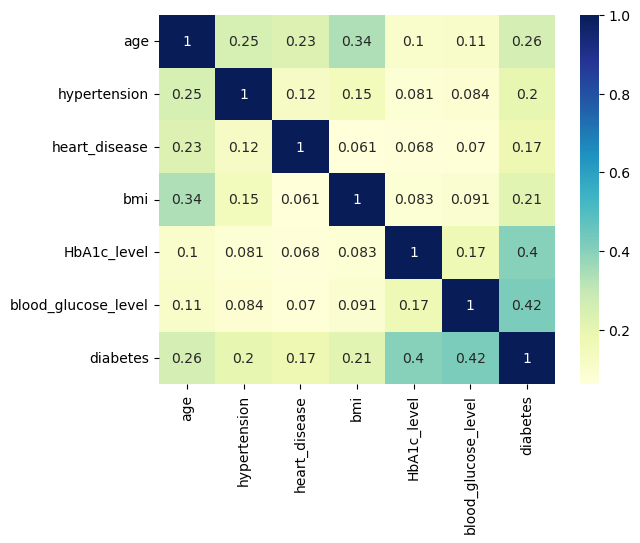

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")


### Outlier Detection:
Since we dont have any missing values and redundant attributes we look for outliers and then remove them using 1.5 inter quartile range


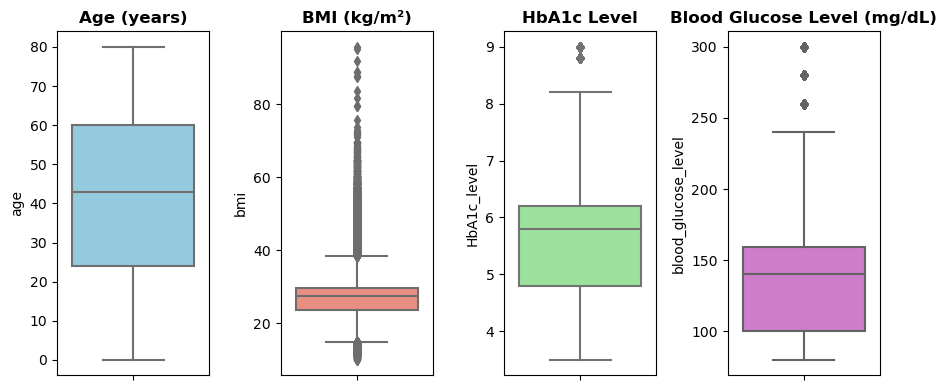

In [ ]:
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
colors = ['skyblue', 'salmon', 'lightgreen', 'orchid']

fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(9, 4))

title_mapping = {
    'age': 'Age (years)',
    'bmi': 'BMI (kg/m²)',
    'HbA1c_level': 'HbA1c Level',
    'blood_glucose_level': 'Blood Glucose Level (mg/dL)'
}

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color=colors[i])
    axes[i].set_title(title_mapping[col], fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
data=df.copy()
for col in numerical_cols: #finding the outliers
    print(col)
     #calculating the first quartile (Q1), third quartile (Q3), and interquartile range (IQR)
    Q1 = np.percentile(data[col], 25,
                   interpolation = 'midpoint')
    Q3 = np.percentile(data[col], 75,
                   interpolation = 'midpoint')
    IQR = Q3 - Q1
    print("Old Shape: ", data.shape)#original shape of data

    # Upper bound
    upper=Q3+1.5*IQR
    upper_index=data[data[col]>=upper].index
    # Lower bound
    lower=Q1-1.5*IQR
    lower_index=data[data[col]<=lower].index
    #removing outliers by dropping rows with indices identified as outliers
    data.drop(upper_index,inplace=True)
    data.drop(lower_index,inplace=True)


    print("New Shape: ", data.shape)

age
Old Shape:  (100000, 9)
New Shape:  (100000, 9)
bmi
Old Shape:  (100000, 9)
New Shape:  (92914, 9)
HbA1c_level
Old Shape:  (92914, 9)
New Shape:  (91804, 9)
blood_glucose_level
Old Shape:  (91804, 9)
New Shape:  (90387, 9)


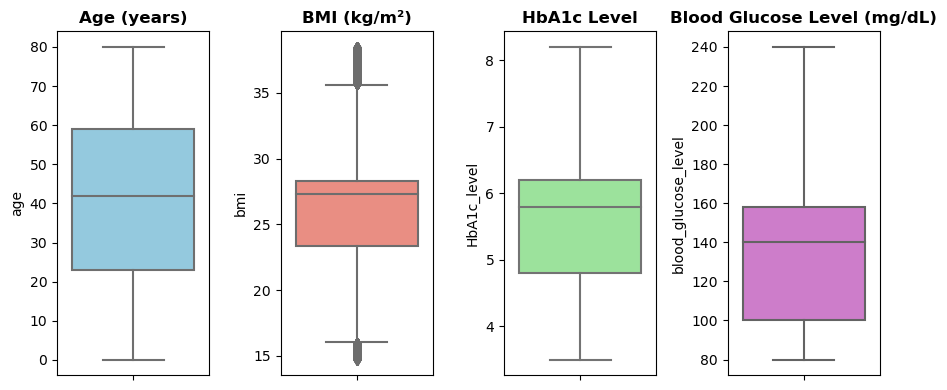

In [ ]:
#Box plot after removing the outliers
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_cols), figsize=(9, 4))

title_mapping = {
    'age': 'Age (years)',
    'bmi': 'BMI (kg/m²)',
    'HbA1c_level': 'HbA1c Level',
    'blood_glucose_level': 'Blood Glucose Level (mg/dL)'
}

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=data[col], ax=axes[i], color=colors[i])
    axes[i].set_title(title_mapping[col], fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
#unique categorical values
cat_cols = ['gender', 'smoking_history', 'diabetes']

for col in cat_cols:
    print(f"Unique values in {col}: {data[col].unique()}")

Unique values in gender: ['Female' 'Male' 'Other']
Unique values in smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Unique values in diabetes: [0 1]


### Removing Constant/Unnecessary Features:
 Here we Identify and remove constant features from the dataset, as they do not provide valuable information for model training.

In [ ]:
# Check for constant features
constant_features = [feat for feat in data.columns if data[feat].nunique() == 1]
print("Constant Features:", constant_features)

# Remove constant features
data.drop(columns=constant_features, inplace=True)

# Display the first few rows of the updated dataframe
data.shape


Constant Features: []


(90387, 9)

### Categorical Variable Encoding:
 In this step, we convert categorical variables like 'gender' and 'smoking_history' into numerical format using one-hot encoding or label encoding.

In [ ]:
# categorical data conversion to dummies (One-Hot-Encoding)
data_encoded = pd.get_dummies(data, columns=['gender', 'smoking_history'])
data_encoded = data_encoded.iloc[:, :-1] #dropping the last col because its redundant
data_encoded.head()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0


### Data Segregation:
 We divide the dataset into features (X), containing explanatory variables, and the target variable (y), which represents the outcome variable for predictive modeling.

In [ ]:
#separating features (X) and target variable (y)
X = data_encoded.drop('diabetes', axis=1)  # features=all columns except 'diabetes'
y = data_encoded['diabetes']  # target variable

#the shape of features and target variable
print("Shape of Features (X):", X.shape)
print("Shape of Target Variable (y):", y.shape)


Shape of Features (X): (90387, 14)
Shape of Target Variable (y): (90387,)


### Addressing Class Imbalance:
 Here we examine the distribution of the target variable 'diabetes' and implement strategies like oversampling, undersampling, or class weights during model training if imbalance is detected.

Class Distribution:
0    85892
1     4495
Name: diabetes, dtype: int64
Imbalance Ratio: 0.05233316257625856


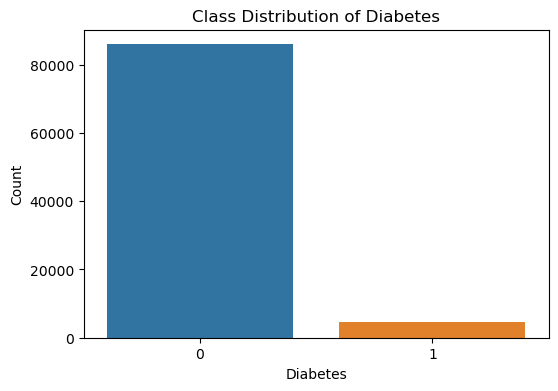

In [ ]:
#class distribution of the target variable
class_distribution = data_encoded['diabetes'].value_counts()
print("Class Distribution:")
print(class_distribution)

#calculating the imbalance ratio
imbalance_ratio = class_distribution[1] / class_distribution[0]
print("Imbalance Ratio:", imbalance_ratio)


plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=data_encoded)
plt.title('Class Distribution of Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()


# Start of the Experimental Design

## Balancing the data and Spliting Data into Training and Testing Sets
 We Split the dataset into training and testing subsets for evaluating model performance, maintaining a stratified split to maintain the distribution of the target variable.


In [ ]:
# Splitting data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE on training data only to avoid data leakage
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
new_class_distribution = pd.Series(y_train_smote).value_counts()
print("New Class Distribution:")
print(new_class_distribution)


New Class Distribution:
0    68713
1    68713
Name: diabetes, dtype: int64


In [ ]:
# X_train = pd.DataFrame(X_train)  # Convert X_train to DataFrame
# y_train = pd.Series(y_train)
type(X_train)

pandas.core.frame.DataFrame

##### The original training set (X_train, y_train) had an imbalanced class distribution.
After applying SMOTE to the training set (X_train, y_train), the number of samples in the minority class was increased to balance the dataset (X_train_smote, y_train_smote).

In [ ]:
# Display the shape of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_train_smote:", X_train_smote.shape)
print("Shape of X_test:", X_test.shape)


print("Shape of y_train:", y_train.shape)
print("Shape of y_train_smote:", y_train_smote.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (72309, 14)
Shape of X_train_smote: (137426, 14)
Shape of X_test: (18078, 14)
Shape of y_train: (72309,)
Shape of y_train_smote: (137426,)
Shape of y_test: (18078,)


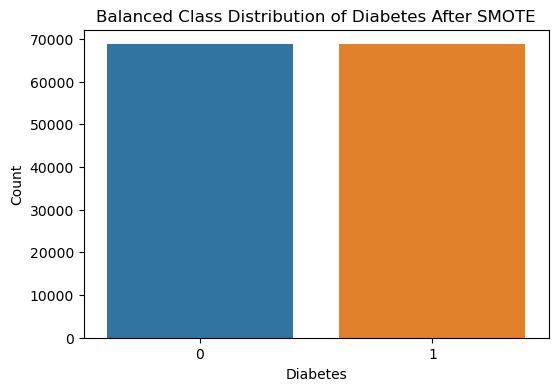

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_smote)
plt.title('Balanced Class Distribution of Diabetes After SMOTE')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

### Scaling:
 We use StandardScaler() to normalize numerical features such as 'age', 'bmi', 'HbA1c_level', and 'blood_glucose_level' in the dataset, to a similar range to ensure that they contribute equally during model training.

In [ ]:
# # Extract numerical columns
# numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# # Scale numerical features
# scaler = StandardScaler()
# df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# # Display the first few rows of the scaled dataframe
# df_encoded.head()


In [ ]:
# Scale on the training data
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_train_smote=scaler.fit_transform(X_train_smote)

X_test = scaler.transform(X_test)

# X_train
# X_train_smote



In [ ]:
type(X_train)

numpy.ndarray

In [ ]:

# # Define a function to report specificity
# def specificity_score(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     specificity = tn / (tn + fp)
#     return specificity


In [ ]:
# setting a random seed for reproducibility
np.random.seed(42)

# ML Modeling

We are exploring six classifiers: Random Forest, K-Nearest Neighbors, Naive Bayes, Logistic Regression, Decision Tree, and Gradient Boosting. Each classifier will be evaluated three times using different strategies:

1. Split Data with Stratification:
The classifiers will be trained and tested on the original, stratified data split into training and testing sets.

2. Balanced Data Using Oversampled Training Sets (SMOTE):
The classifiers will also be trained on balanced data achieved by oversampling the minority class using the Synthetic Minority Over-sampling Technique (SMOTE).

By assessing each classifier under these different conditions, we aim to evaluate their performance.

## Random Forest

### Random Forest on Data with Stratification


In [ ]:
# defining the ratio of training data we'll use for cross-validation
tr_ratio = .2 # using 20% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))

scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
rf = RandomForestClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'n_estimators': range(10, int(len(X_train) * tr_ratio / 10), int(len(X_train) * tr_ratio / 200))
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
#
grid_search.fit(X_train[smp], y_train.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)



# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity': lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Random Forest'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_rf_str = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF
# print(f"Confusion Matrix: \n{cm_df_rf_str}")


# # calculating the ROC curve for visualizing model performance
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# # plotting the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % scores_df['AUC'])
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic(ROC) Curve')
# plt.grid(alpha=.3)
# plt.legend(loc="lower right")
# plt.show()

# # spe=specificity_score(y_test, y_pred)
# # print('specificity using func:',round(spe, 2))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best hyperparameters: {'n_estimators': 298}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity     Model Name
0      0.96        1.0      0.42  0.63    0.26          1.0  Random Forest


In [ ]:
print('X_train sample:', len(X_train[smp]))
print('y_train sample:',len(y_train.values[smp]))
print('X_test:', len(X_test))

X_train sample: 14461
y_train sample: 14461
X_test: 18078


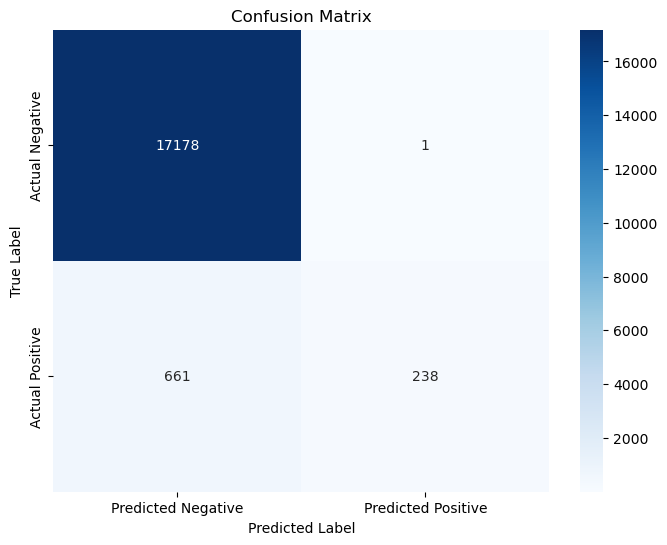

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_rf_str, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Random Forest on Balanced Data Using SMOTE:

In [ ]:
# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))

scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
rf = RandomForestClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'n_estimators': range(10, int(len(X_train_smote[smp]) * tr_ratio / 10), int(len(X_train_smote[smp]) * tr_ratio / 200))
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
#
grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Random Forest'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_rf_smote = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF


Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best hyperparameters: {'n_estimators': 361}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity     Model Name
0      0.94       0.45      0.52  0.79    0.62         0.96  Random Forest


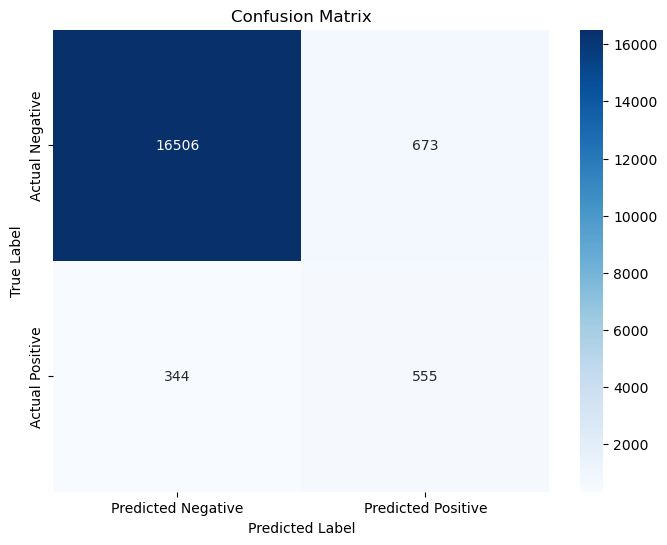

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_rf_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## K Nearest Neighbor

### K nearest neighbor on Data with Stratification

In [ ]:
# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))


# defining the model
knn = KNeighborsClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'n_neighbors': range(10,int(len(X_train)*tr_ratio/10),int(len(X_train)*tr_ratio/200))
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train[smp], y_train.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'K Nearest Neighbor'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_knn_str = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF




Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_neighbors': 10}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity  \
0      0.95       0.78      0.06  0.52    0.03          1.0   

           Model Name  
0  K Nearest Neighbor  


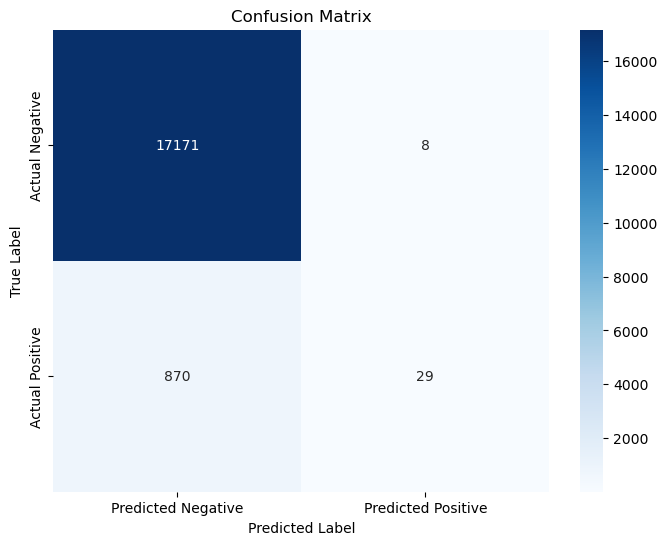

In [ ]:
# cm_df_knn_str=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_knn_str, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### K nearesr neighbors on Balanced Data Using SMOTE:

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))

scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
knn = KNeighborsClassifier(weights='distance')

# Defining a reasonable range for K
param_grid = {
    'n_neighbors': range(10,int(len(X_train)*tr_ratio/10),int(len(X_train)*tr_ratio/200))
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
#
grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}

# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Random Forest'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_knn_smote = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF




Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best hyperparameters: {'n_neighbors': 10}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity     Model Name
0       0.9       0.28      0.39  0.78    0.64         0.91  Random Forest


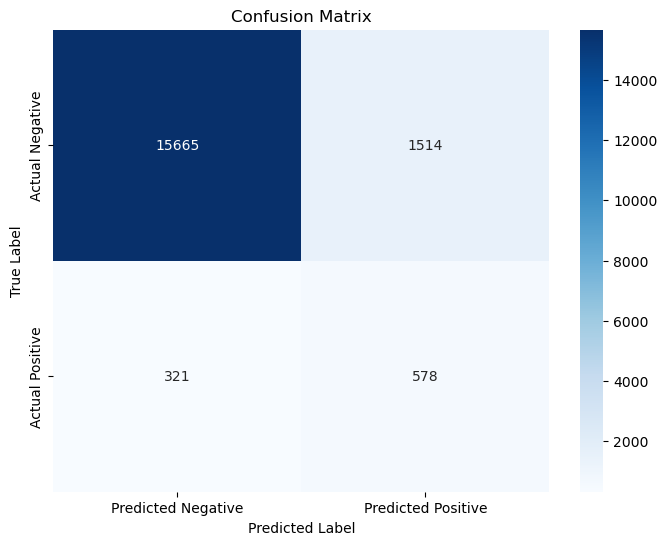

In [ ]:
# cm_df_knn_smote=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_knn_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Naive Bayes

### Naive Bayes on Data with Stratification

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = .2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
nb = GaussianNB()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=10)
}
# 'var_smoothing': np.logspace(-1, -10, num=100)

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
                        #    , scoring=scoring)
grid_search.fit(X_train[smp], y_train.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Naive Bayes'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_nb_str= pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'var_smoothing': 1e-09}

Scores: 
   Accuracy  Precision  F1-Score  AUC  Recall  Specificity   Model Name
0      0.95        0.0       0.0  0.5     0.0          1.0  Naive Bayes


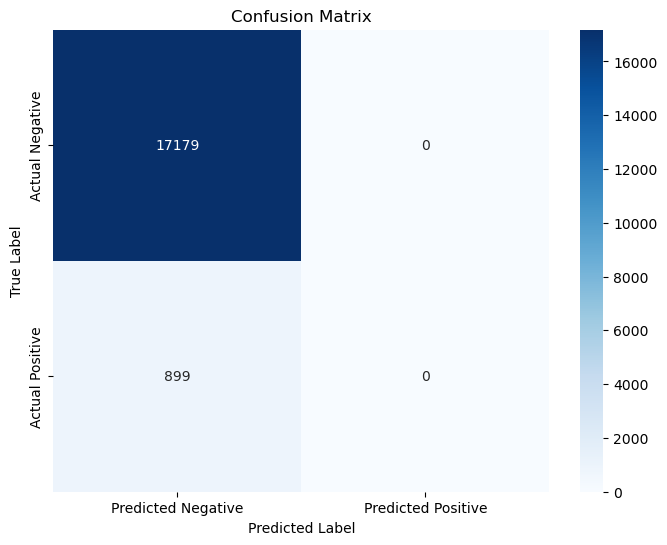

In [ ]:
# cm_df_nb_str=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_nb_str, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Naive Bayes on Balanced Data Using SMOTE:

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
nb = GaussianNB()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=10)
}
# 'var_smoothing': np.logspace(-1, -10, num=100)

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
# y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Naive Bayes'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_nb_smote= pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'var_smoothing': 1.0}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity   Model Name
0      0.66       0.11      0.19  0.74    0.83         0.65  Naive Bayes


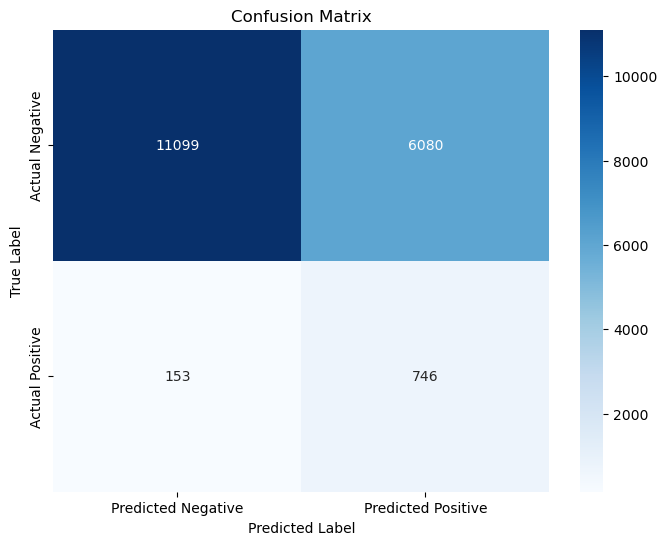

In [ ]:
# cm_df_nb_smote=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_nb_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Logistic Regression

### Logistic Regression on Data with Stratification

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
lr = LogisticRegression(n_jobs=-1)

# specify the range of hyperparameters that we want to tune
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],'C':[100, 10, 1.0, 0.1, 0.01]
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train[smp], y_train.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}



# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Logistic Regression'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_lr_str = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF




Fitting 5 folds for each of 15 candidates, totalling 75 fits


Best hyperparameters: {'C': 100, 'solver': 'newton-cg'}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity  \
0      0.96        1.0      0.19  0.55     0.1          1.0   

            Model Name  
0  Logistic Regression  


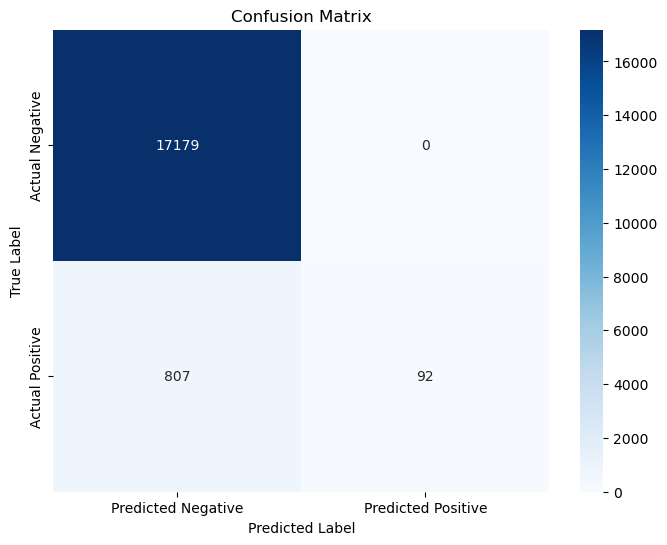

In [ ]:
# cm_df_lr_str=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_lr_str, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Logistic Regression on Balanced Data Using SMOTE:

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.1  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
lr = LogisticRegression(n_jobs=-1)

# specify the range of hyperparameters that we want to tune
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],'C':[100, 10, 1.0, 0.1, 0.01]
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Logistic Regression'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_lr_smote = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF



Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters: {'C': 0.01, 'solver': 'liblinear'}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity  \
0      0.89       0.28       0.4  0.81    0.72          0.9   

            Model Name  
0  Logistic Regression  


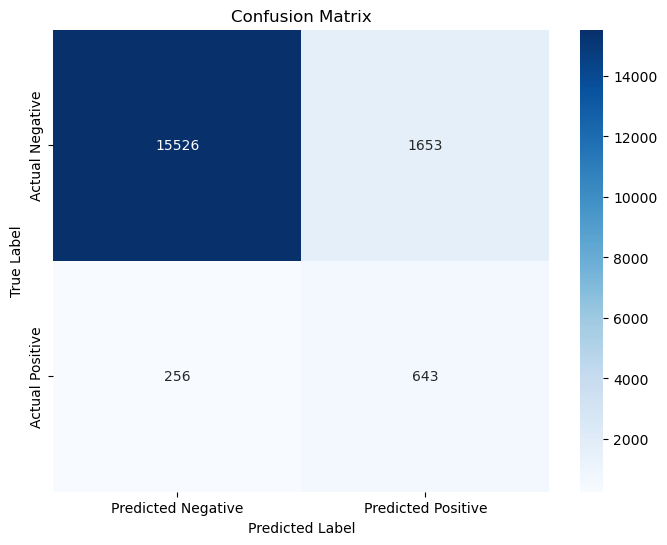

In [ ]:
# cm_df_lr_smote=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_lr_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Decision Tree

### Decision Tree on Data with Stratification

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
dt =  DecisionTreeClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'criterion' : ["gini", "entropy"]
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train[smp], y_train.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Decision Tree'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_dt_str = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF




Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'criterion': 'gini'}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity     Model Name
0      0.95       0.52      0.41  0.66    0.34         0.98  Decision Tree


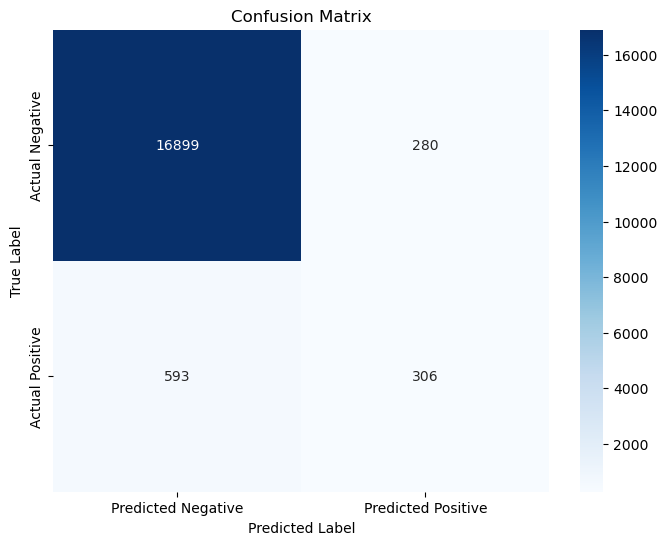

In [ ]:
# cm_df_dt_str=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_dt_str, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Decision Tree on Balanced Data Using SMOTE:

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.2  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
dt =  DecisionTreeClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'criterion' : ["gini", "entropy"]
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}



# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'Decision Tree'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_dt_smote = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'criterion': 'entropy'}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity     Model Name
0      0.94       0.41      0.49  0.78    0.61         0.95  Decision Tree


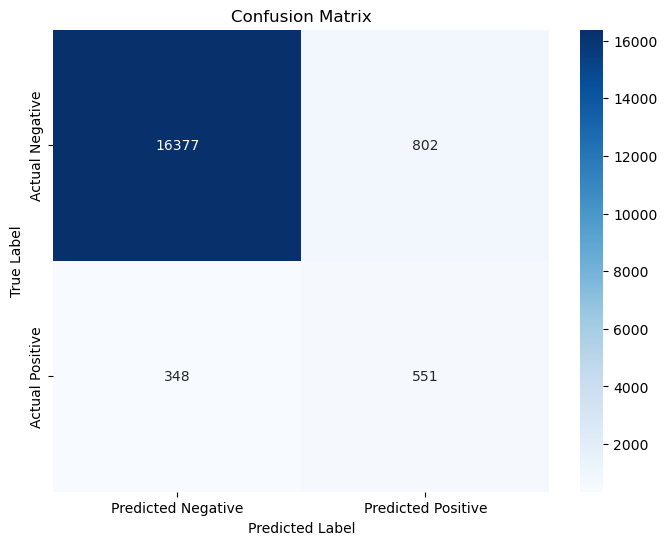

In [ ]:
# cm_df_dt_smote=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_dt_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## GradientBoosting

### GradientBoosting on Data with Stratification

In [ ]:

# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.01  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
gb =  GradientBoostingClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'n_estimators': [100, 200, 300],
       'learning_rate': [0.1, 0.05, 0.01],
       'max_depth': [3, 4, 5]
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train[smp], y_train.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}



# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'GradientBoosting'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_gb_str = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity        Model Name
0      0.96       0.94      0.43  0.64    0.28          1.0  GradientBoosting


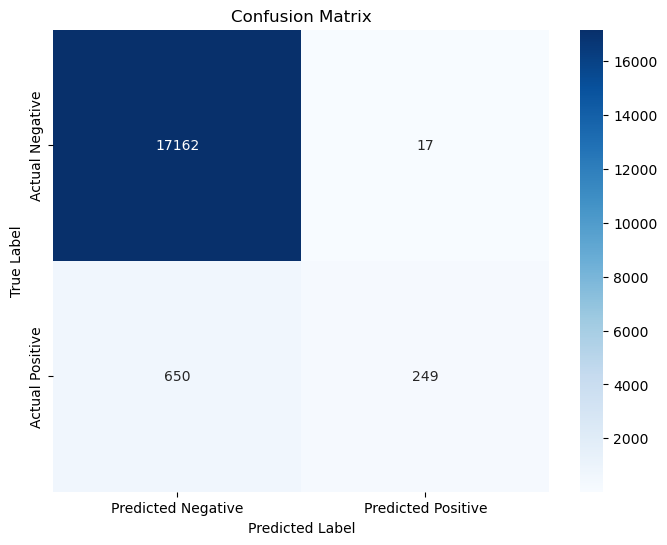

In [ ]:
# cm_df_gb_str=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_gb_str, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### GradientBoosting on Balanced Data Using SMOTE:

In [ ]:


# defining the ratio of training data we'll use for cross-validation
tr_ratio = 0.01  # using 10% of the training data for model tuning

# randomly sample a subset of our training data based on the defined ratio
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))
scoring = metrics.make_scorer(metrics.recall_score) #our chosen evaluation metric for model tuning will be the recall score

# defining the model
gb =  GradientBoostingClassifier()

# specify the range of hyperparameters that we want to tune
param_grid = {
    'n_estimators': [100, 200, 300],
       'learning_rate': [0.1, 0.05, 0.01],
       'max_depth': [3, 4, 5]
}

# using GridSearchCV to search across the specified hyperparameter grid with 3-fold cross-validation
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=scoring)
grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

# with the best model selected through tuning, let's make predictions on the test set
print("Best hyperparameters:", grid_search.best_params_)

#best model
best_model=grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# calculating the probabilities of the positive class predictions
y_pred_proba = grid_search.predict_proba(X_test)[::,1]

# defining a dictionary of evaluation metrics to assess the model's performance
metr_dic = {
    'Accuracy': metrics.accuracy_score,
    'Precision': metrics.precision_score,
    'F1-Score': metrics.f1_score,
    'AUC': metrics.roc_auc_score,
    'Recall': metrics.recall_score,
    'Specificity':  lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}


# calculating all the scores for the model
scores = {}
for metric_name, metric_func in metr_dic.items():
    score = metric_func(y_test, y_pred)
    scores[metric_name] = round(score, 2)

# including the model name
scores['Model Name'] = 'GradientBoosting'

# creating and printing a DataFrame for the scores
scores_df = pd.DataFrame(scores, index=[0])

print("\nScores: ")
print(scores_df)

# calculating the confusion matrix to visualize predicted vs. actual labels
cm = confusion_matrix(y_test, y_pred)
cm_df_gb_smote = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']) #putting it in a DF





Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

Scores: 
   Accuracy  Precision  F1-Score   AUC  Recall  Specificity        Model Name
0      0.94       0.41      0.51  0.81    0.66         0.95  GradientBoosting


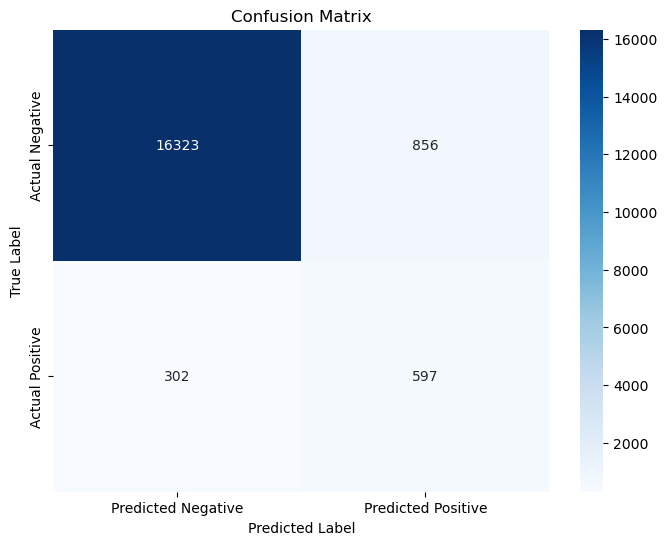

In [ ]:
# cm_df_gb_smote=cm_df
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_gb_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Finding the best model

### Data with Stratification

In [ ]:
# Ratio of the training data actually used for cross-validation
tr_ratio = 0.2
smp = np.random.randint(0, len(X_train), int(tr_ratio * len(X_train)))# Randomly sample a subset of your training data according to the ratio

models_dic={'k-Nearest Neighbors':KNeighborsClassifier(n_jobs=-1),
            'Naive Bayes':GaussianNB(),
            'Logistic Regression':LogisticRegression(n_jobs=-1),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest':RandomForestClassifier(n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier() }

metr_dic={'Accuracy':metrics.accuracy_score,
          'Precision':metrics.precision_score,
          'F1-Score':metrics.f1_score,
          'AUC':metrics.roc_auc_score,
          "Recall":metrics.recall_score,
          "Specificity":lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}
metr_df_stra=pd.DataFrame(index=list(models_dic.keys()),columns=list(metr_dic.keys()))

# scoring = metrics.make_scorer(metrics.recall_score)

params = {
'k-Nearest Neighbors':{'n_neighbors': range(10,int(len(X_train)*tr_ratio/10),int(len(X_train)*tr_ratio/200))},
'Random Forest':{'n_estimators': range(10,int(len(X_train)*tr_ratio/10),int(len(X_train)*tr_ratio/200))},
'Naive Bayes':{'var_smoothing': np.logspace(0,-9, num=10)},
'Logistic Regression':{'solver': ['newton-cg', 'lbfgs', 'liblinear'],'C':[100, 10, 1.0, 0.1, 0.01]},
'Decision Tree':{'criterion' : ["gini", "entropy"]},
'Gradient Boosting': {'n_estimators': [100, 200, 300],
       'learning_rate': [0.1, 0.05, 0.01],
       'max_depth': [3, 4, 5]}
}

# Use GridSearchCV to tune hyperparameters and evaluate models
for model_name, model in models_dic.items():
    print('Performing calculations for:', model_name)
    scores=[]
    for metric_name in metr_dic.keys():
        scoring = metrics.make_scorer(metr_dic[metric_name])
        grid_search = GridSearchCV(model, params[model_name], cv=5, verbose=0)
        grid_search.fit(X_train[smp], y_train.values[smp])

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Predict on the test set using the best model
        y_pred_test = best_model.predict(X_test)
        test_score=metr_dic[metric_name](y_test,y_pred_test)
        print(metric_name+':',test_score)
        scores.append(test_score)
    metr_df_stra.loc[model_name]=scores


Performing calculations for: k-Nearest Neighbors
Accuracy: 0.9519858391414979
Precision: 0.8604651162790697
F1-Score: 0.07855626326963906
AUC: 0.5204037886492685
Recall: 0.041156840934371525
Specificity: 0.9996507363641656
Performing calculations for: Naive Bayes
Accuracy: 0.9383781391746875
Precision: 0.2912621359223301
F1-Score: 0.21216407355021216
AUC: 0.5728025933310589
Recall: 0.1668520578420467
Specificity: 0.978753128820071
Performing calculations for: Logistic Regression
Accuracy: 0.9548069476712026
Precision: 1.0
F1-Score: 0.1671763506625892
AUC: 0.5456062291434928
Recall: 0.09121245828698554
Specificity: 1.0
Performing calculations for: Decision Tree
Accuracy: 0.9529262086513995
Precision: 0.551594746716698
F1-Score: 0.4117647058823529
AUC: 0.6591941903872728
Recall: 0.3325917686318131
Specificity: 0.9845741894173118
Performing calculations for: Random Forest
Accuracy: 0.9632702732603164
Precision: 0.983402489626556
F1-Score: 0.41688654353562016
AUC: 0.6317840203922306
Recall

In [ ]:
metr_df_stra.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)


,Accuracy,Precision,F1-Score,AUC,Recall,Specificity
k-Nearest Neighbors,0.95,0.86,0.08,0.52,0.04,1.00
Naive Bayes,0.94,0.29,0.21,0.57,0.17,0.98
Logistic Regression,0.95,1.00,0.17,0.55,0.09,1.00
Decision Tree,0.95,0.55,0.41,0.66,0.33,0.98
Random Forest,0.96,0.98,0.42,0.63,0.26,1.00
Gradient Boosting,0.96,0.91,0.42,0.64,0.28,1.00


In [ ]:
# metr_df_stra.to_csv('metr_df_stra.csv')

### Data with SMOTE

In [ ]:
# Ratio of the training data actually used for cross-validation
tr_ratio = 0.2
smp = np.random.randint(0, len(X_train_smote), int(tr_ratio * len(X_train_smote)))# Randomly sample a subset of your training data according to the ratio

models_dic={'k-Nearest Neighbors':KNeighborsClassifier(n_jobs=-1),
            'Naive Bayes':GaussianNB(),
            'Logistic Regression':LogisticRegression(n_jobs=-1),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest':RandomForestClassifier(n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier() }

metr_dic={'Accuracy':metrics.accuracy_score,
          'Precision':metrics.precision_score,
          'F1-Score':metrics.f1_score,
          'AUC':metrics.roc_auc_score,
          "Recall":metrics.recall_score,
          "Specificity":lambda y_true, y_pred: (confusion_matrix(y_true, y_pred)[0, 0] / (confusion_matrix(y_true, y_pred)[0, 0] + confusion_matrix(y_true, y_pred)[0, 1]))}
metr_report_smote=pd.DataFrame(index=list(models_dic.keys()),columns=list(metr_dic.keys()))

scoring = metrics.make_scorer(metrics.recall_score)

params = {
'k-Nearest Neighbors':{'n_neighbors': range(10,int(len(X_train_smote)*tr_ratio/10),int(len(X_train_smote)*tr_ratio/200))},
'Random Forest':{'n_estimators': range(10,int(len(X_train_smote)*tr_ratio/10),int(len(X_train_smote)*tr_ratio/200))},
'Naive Bayes':{'var_smoothing': np.logspace(0,-9, num=10)},
'Logistic Regression':{'solver': ['newton-cg', 'lbfgs', 'liblinear'],'C':[100, 10, 1.0, 0.1, 0.01]},
'Decision Tree':{'criterion' : ["gini", "entropy"]},
'Gradient Boosting': {'n_estimators': [100, 200, 300],
       'learning_rate': [0.1, 0.05, 0.01],
       'max_depth': [3, 4, 5]}
}

# Use GridSearchCV to tune hyperparameters and evaluate models
for model_name, model in models_dic.items():
    print('Performing calculations for:', model_name)
    scores=[]
    for metric_name in metr_dic.keys():
        scoring = metrics.make_scorer(metr_dic[metric_name])
        grid_search = GridSearchCV(model, params[model_name], cv=5, verbose=0, scoring= scoring)
        grid_search.fit(X_train_smote[smp], y_train_smote.values[smp])

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        # Predict on the test set using the best model
        y_pred_test = best_model.predict(X_test)
        test_score=metr_dic[metric_name](y_test,y_pred_test)
        print(metric_name+':',test_score)
        scores.append(test_score)
    metr_report_smote.loc[model_name]=scores






Performing calculations for: k-Nearest Neighbors
Accuracy: 0.9057971014492754
Precision: 0.2863974495217853
F1-Score: 0.3876303487953973
AUC: 0.7606891086790719
Recall: 0.8353726362625139
Specificity: 0.9218231561790559
Performing calculations for: Naive Bayes
Accuracy: 0.6897886934395397
Precision: 0.11609326593836622
F1-Score: 0.2025028441410694
AUC: 0.7382157031235785
Recall: 0.9243604004449388
Specificity: 0.6844403050235753
Performing calculations for: Logistic Regression
Accuracy: 0.9056311538887045
Precision: 0.3012345679012346
F1-Score: 0.4169514695830485
AUC: 0.7980236366140439
Recall: 0.6874304783092324
Specificity: 0.9176319925490425
Performing calculations for: Decision Tree
Accuracy: 0.9351145038167938
Precision: 0.40679245283018867
F1-Score: 0.4864142538975501
AUC: 0.7743850153079649
Recall: 0.5906562847608454
Specificity: 0.9537807788579079
Performing calculations for: Random Forest
Accuracy: 0.9427480916030534
Precision: 0.44527363184079605
F1-Score: 0.5183150183150182


In [ ]:

metr_report_smote.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

,Accuracy,Precision,F1-Score,AUC,Recall,Specificity
k-Nearest Neighbors,0.91,0.29,0.39,0.76,0.84,0.92
Naive Bayes,0.69,0.12,0.20,0.74,0.92,0.68
Logistic Regression,0.91,0.30,0.42,0.80,0.69,0.92
Decision Tree,0.94,0.41,0.49,0.77,0.59,0.95
Random Forest,0.94,0.45,0.52,0.79,0.63,0.96
Gradient Boosting,0.96,0.66,0.59,0.76,0.54,0.99


In [ ]:
# metr_report_smote.to_csv('metr_report_smote.csv')

## Final Results Visualized

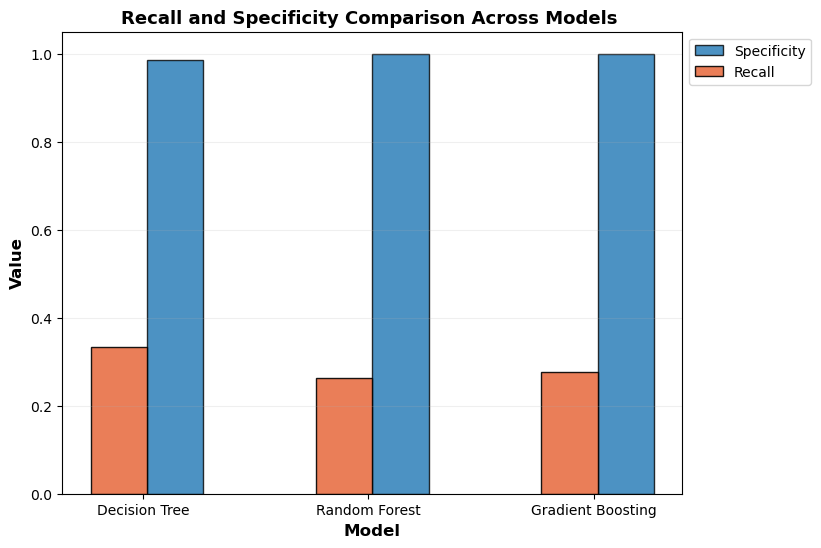

In [ ]:
# Set the width of the bars
barWidth = 0.25

# Select only the last three models
metr_df_stra_last3 = metr_df_stra.tail(3)

# Set position of bar on X axis
r1 = np.arange(len(metr_df_stra_last3['Accuracy']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(8, 6))
# Make the plot
plt.bar(r3, metr_df_stra_last3['Specificity'], width=barWidth, edgecolor='black', label='Specificity', alpha= .8)
plt.bar(r2, metr_df_stra_last3['Recall'], width=barWidth, edgecolor='black', label='Recall', color='#E87046',alpha=.9)
# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold', fontsize=12)
plt.ylabel('Value', fontweight='bold', fontsize=12)
plt.xticks([r + barWidth/.7 for r in range(len(metr_df_stra_last3['Accuracy']))], metr_df_stra_last3.index)

# # Adjust the x-ticks to be in the middle of the two bars
# plt.xticks([r + barWidth for r in range(len(metr_df_stra_last3['Accuracy']))])
# Create legend & Show graphic
plt.title('Recall and Specificity Comparison Across Models ',fontweight='bold', fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=.2)
plt.show()


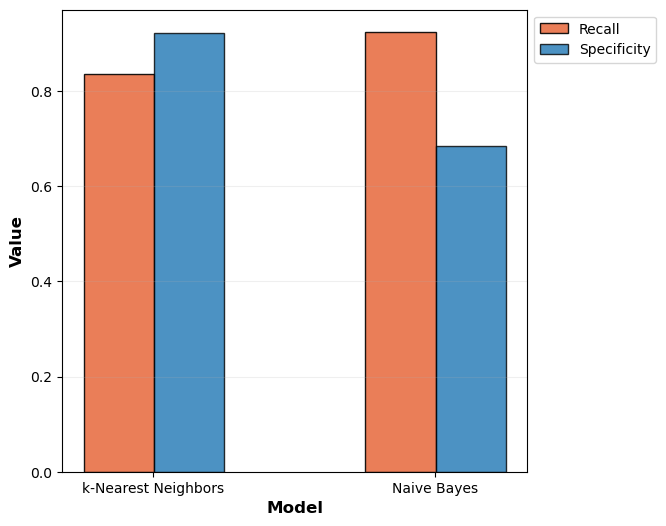

In [ ]:

# Set the width of the bars
barWidth = 0.25
metr_report_smote_First2 = metr_report_smote.head(2)
# Set position of bar on X axis
r1 = np.arange(len(metr_report_smote_First2['Precision']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(6, 6))
# Make the plot
# plt.bar(r1, metr_report_smote['Precision'], width=barWidth, edgecolor='black', label='Precision', alpha= .5)
plt.bar(r2, metr_report_smote_First2['Recall'], width=barWidth, edgecolor='black', label='Recall', alpha= .9, color='#E87046')
plt.bar(r3, metr_report_smote_First2['Specificity'], width=barWidth, edgecolor='black', label='Specificity', alpha= .8)
# , color='#803E42'
# , color='#93D1A3'
# , color='#FA7551'
# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold', fontsize=12)
plt.ylabel('Value', fontweight='bold', fontsize=12)
plt.xticks([r + barWidth/.67 for r in range(len(metr_report_smote_First2['Precision']))], metr_report_smote_First2.index)
# [r + barWidth/.79 for r in range(len(metr_df_stra_last3['Accuracy']))]
# Create legend & Show graphic
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Recall and Specificity Comparison Across Models ',fontweight='bold', fontsize=13)
plt.grid(axis='y', alpha=.2)
plt.show()


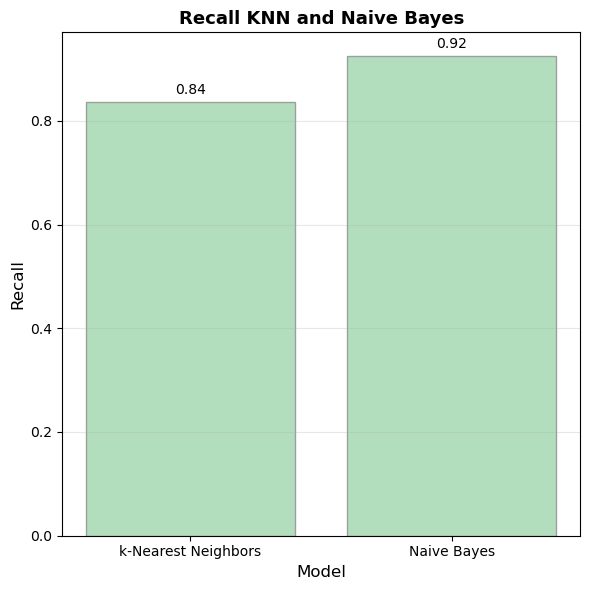

In [ ]:
recall_values = metr_report_smote['Recall'].iloc[:2]
model_names = metr_report_smote.index[:2]
# recall values
# recall_values = metr_report['Recall']
# model_names = metr_report.index
plt.figure(figsize=(6, 6))
plt.bar(model_names, recall_values, edgecolor='grey',color='#93D1A3', alpha= .7)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Recall KNN and Naive Bayes', fontweight='bold', fontsize=13)
plt.xticks()  # Rotate x-axis labels for readability


# add numerical values above the bars
for i, recall in enumerate(recall_values):
    plt.text(i, recall + 0.01, f'{recall:.2f}', ha='center', va='bottom')


plt.grid(axis='y', alpha=.3)
plt.tight_layout()
plt.show()


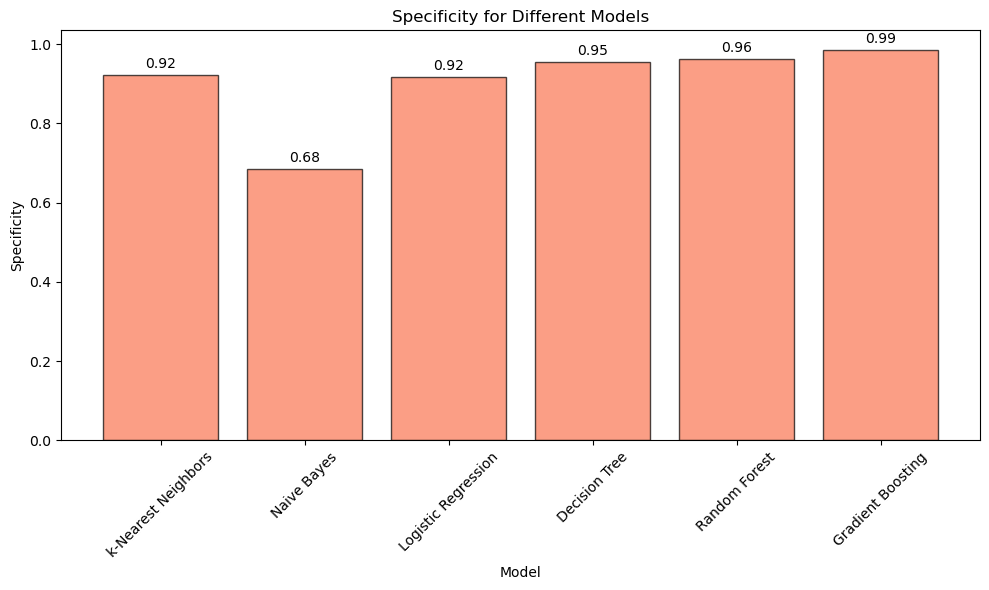

In [ ]:
# recall values
recall_values = metr_report_smote['Specificity']
model_names = metr_report_smote.index
plt.figure(figsize=(10, 6))
plt.bar(model_names, recall_values, edgecolor='black', color='#FA7551', alpha= .7)
plt.xlabel('Model')
plt.ylabel('Specificity')
plt.title('Specificity for Different Models')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# add numerical values above the bars
for i, recall in enumerate(recall_values):
    plt.text(i, recall + 0.01, f'{recall:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


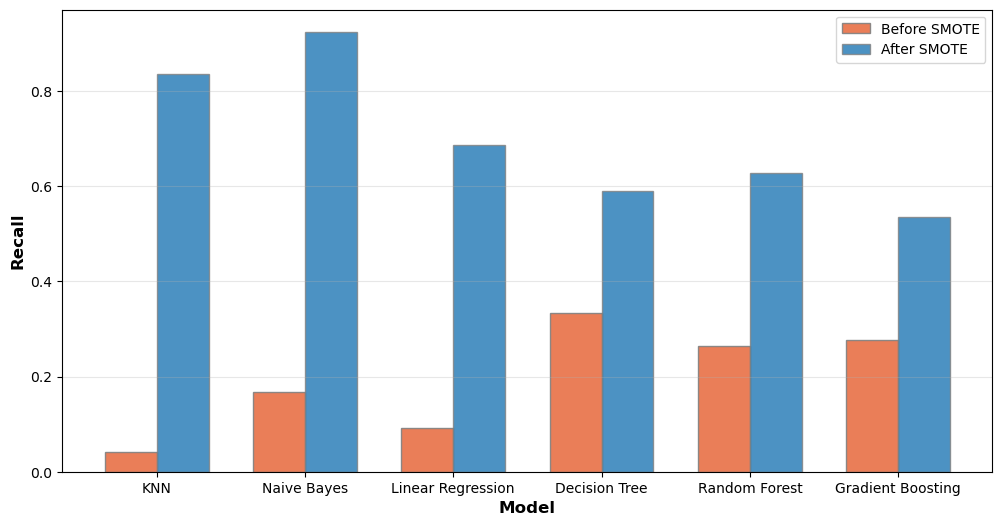

In [ ]:
bar_width = 0.35
models = [
    'KNN',
    'Naive Bayes',
    'Linear Regression',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting'
]
# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plotting the bars
plt.figure(figsize=(12, 6))
plt.bar(r1, metr_df_stra['Recall'], width=bar_width, edgecolor='grey', label='Before SMOTE', color='#E87046',alpha=.9)
plt.bar(r2, metr_report_smote['Recall'], width=bar_width, edgecolor='grey', label='After SMOTE',alpha=.8)

# Adding labels and title
plt.xlabel('Model', fontweight='bold', fontsize=12)
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.ylabel('Recall', fontsize=12, fontweight='bold')
plt.title('Comparison of Recall by Model Before SMOTE and after SMOTE',fontweight='bold', fontsize=13)
plt.legend()

# Show plot

plt.grid(axis='y', alpha=.3)
plt.show()
